## Adiabatic parameters from neutron's paths
Emma Klemets   
Nov. 2022   
Full documentation of the theory can be found at: https://www.overleaf.com/read/rfkkhhwwfjct

Looking at adiabatic transport from the side of the physical parameters, mainly the magnetic field.

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from scipy import ndimage
from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib.colors as mpl_colors
import matplotlib as mpl
from scipy.spatial.transform import Rotation as Rot

from stl import mesh
from mpl_toolkits import mplot3d

In [2]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
import AdiabaticEquations as Adi
%load_ext autoreload
%autoreload 2

In [3]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1,

In [4]:
# gamma_n

### Some notes

In [5]:
# vn = 8 #/ms
# # linear
# B = 100e-6
# dbdx = 80e-6*1e2
# val = Adi.K_equ_dbdx(B, dbdx, vn)
# print(val)

# #rot
# B = 10e-6
# dx = 25*1e-2
# val = Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)
# print(val)


[11-10 8:41 a.m.] Jeffery W. Martin
Also, just to set a scale for this problem:

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the UCN moves in a straight line at 8 m/s.

[11-10 8:42 a.m.] Jeffery W. Martin
Let's say the magnetic field rotates by 90 degrees during this time.

[11-10 8:43 a.m.] Jeffery W. Martin
Actually, let's say it rotates by 90 degrees in the course of 1 m of travel by the neutron.

[11-10 8:43 a.m.] Jeffery W. Martin
And let's say the value of the field is typically 1 mT.

[11-10 8:43 a.m.] Jeffery W. Martin
For this situation, I get k=15,000



In [6]:
#trying out Jeff's numbers, matches up
v_vec = np.array([8, 0, 0]) #m/s

B_1 = np.array([1, 0, 0])*1e-6 #=1uT
B_2 = np.array([0, 1, 0])*1e-6 #=1uT
r_1 = np.array([0, 0, 0]) 
r_2 = np.array([1, 0, 0]) #dx = 1m

Adi.K_equ3_14(v_vec, B_1, B_2, r_1, r_2)

14.582346536127906

In [7]:
#scalar imputs for simplicity
#speed of your neutrons
vn = 8 #/ms
#magnitude of your magnetic field
B = 500*1e-6 #T
#distance travels during the turn
dx = .2 #m

#calculates the k value for a 90 degrees turn with a uniform magnitude magnetic field (B)
#for a given neutron speed (vn) and distance of the turn (dx) 
Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)

1458.234653612791

In [8]:
#addes labels to contour lines nicely
def fmt_lable(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$k$ = {s}" if plt.rcParams["text.usetex"] else f"$k$ = {s}"

#returns the index of the closest value to N in a list generated 
#from the unique values in a given column of a df
def FindClosest(df, N, val):
    dfun = df[val].unique()
    # print(len(dfun))
    difference_array = np.absolute(dfun-N)
    index = difference_array.argmin()
    return index

## Function of B field and arc length (for 90 deg turn)

Uses Pierre equ 3.14, assumes B is constant throughout the rotation.

In [9]:
#widget inline

"""
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""
def rangeOfdx_forK(B_arr, dx_arr, Vmin=None, Vmax=None):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dx in dx_arr:
            val = Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df = df.pivot("B", "dx", "k")

    df = df.reindex(index=df.index[::-1])
    # print(k_array)

    fig, ax = plt.subplots(figsize=(6, 5))
    if isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(), linewidths=0)
    else:
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)
    
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=10)

    ax.collections[0].colorbar.set_label("k")
    # ax.set_yscale("log")
    

   # format text labels
    fmt = '{:0.1f}' #dx
    i = 0
    xticklabels = []
    for item in ax.get_xticklabels():
        # print(item.get_text())
        item.set_text(fmt.format(float(item.get_text())*1e6/100))
        if i%2==0:#removes every other tick label
            xticklabels += [item]
        else:
            xticklabels += [""]

        i+=1

    fmt = '{:0.1f}'
    #B
    yticklabels = []
    j=0
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())*1e6))
        if j%2==0:#removes every other tick label
            yticklabels += [item]
        else:
            yticklabels += [""]
        j+=1

    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(xticklabels)#,  rotation=0)
    ax.set_xlabel("$\Delta x$ [cm]")
    ax.set_ylabel("B [$\mu$T]")

    ax.set_title("$k$ value for a $90^\circ$ turn in $\Delta x$ distance at a"+
                 " \n given a constant B field and $v = 8$ m/s")#, size=20)
    fig.tight_layout()
    
"""
Same as above, but with custom axis tick labels
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""   
def rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dx in dx_arr:
            val = Adi.pseudoScalar_K_equ3_14_turn(vn, B, dx)
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dx"] = df["dx"]*100 #convert to cm
    
    yticklabels_set = [1, 10, 100, 250, 500]
    # the index position of the tick labels
    yticks = []    
    for label in yticklabels_set:
        idx_pos = FindClosest(df, label, "B")
        yticks.append(len(df["B"].unique())-idx_pos)
           
    xticklabels_set = [.1, 10, 20, 30]
    # the index position of the tick labels
    xticks = []    
    for label in xticklabels_set:
        idx_pos = FindClosest(df, label, "dx")
        xticks.append(idx_pos)
    
    df = df.pivot("B", "dx", "k")
    df = df.reindex(index=df.index[::-1])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    if R_G:
        #https://matplotlib.org/stable/gallery/color/custom_cmap.html
        #vibrant R/G
        # colors = [(0, (0.94118, 0.25882, 0.25882)), (1, (0.23137, 0.67059, 0.23137))]  # R -> G
        #less vibrant
        colors = [(0, 'lightcoral'), (1, 'darkseagreen')]  # R -> G
        
        n_bin = 2
        cmap_name = 'my_list'
        
        bounds = [0, 30, 45]
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        q = sns.heatmap(df, cmap=cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N), 
                        linewidths=0, rasterized=True)
        # ax.collections[0].colorbar.set_ticklabels(['nonadiabatic','k = 30','adiabatic'])
        
    elif isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(), linewidths=0, rasterized=True)        
    else:
        q = sns.heatmap(df, cmap='PRGn', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax, rasterized=True)#, yticklabels=yticklabels_set)
        
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=12)

    # ax.collections[0].colorbar.set_label("k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_set)#,  rotation=0)
    ax.set_xlabel("Arc length ($\Delta x$) [cm]")
    ax.set_ylabel("Magnetic field (B) [$\mu$T]")

    # ax.set_title("$k$ value for a $90^\circ$ turn in $\Delta x$ distance at a"+
    #              " \n given a constant B field and $v = 8$ m/s")#, size=20)
    fig.tight_layout()
    return ax

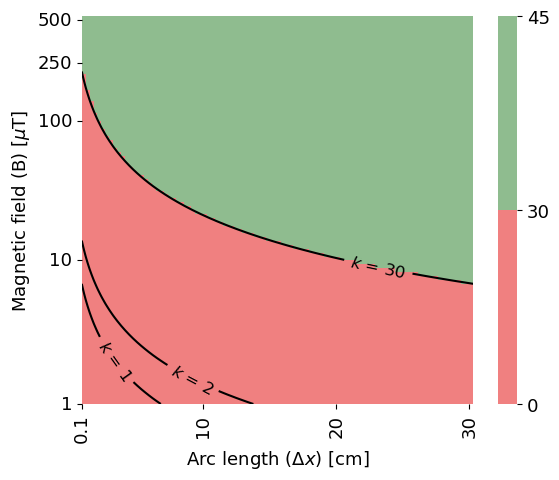

In [10]:
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams.update({'font.size': 13})
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

ax = rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None, R_G=True)
# ax.title("")
# colorEarth = 'g'
# ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
# ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )
# #hmm the spand doesn't match up with my axis ticks
plt.tight_layout()

# plt.savefig('Photos/KvsField/dx_vs_B_klines_redGreen.pdf', transparent=True)
plt.show()

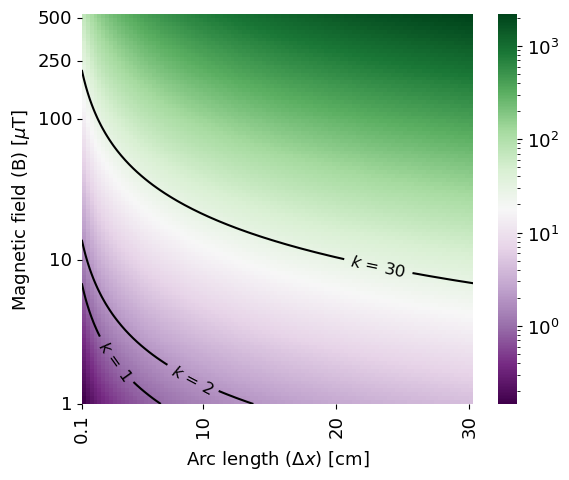

In [11]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None)

# plt.savefig('Photos/KvsField/dx_vs_B_klines.png', transparent=True)
plt.show()

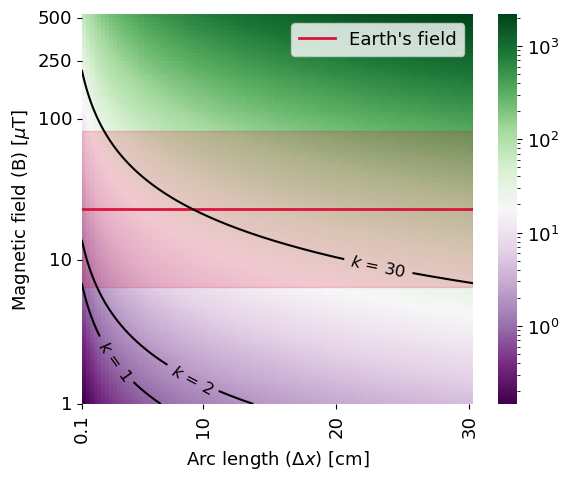

In [12]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)

B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
dx_arr = np.linspace(.01, .30, n)

ax = rangeOfdx_forK_customAxis(B_arr, dx_arr, Vmin=None, Vmax=None)
colorEarth = 'crimson'
ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )
#hmm the spand doesn't match up with my axis ticks
plt.legend(loc='upper right')
plt.tight_layout()

# plt.savefig('Photos/KvsField/dx_vs_B_klines_earth.pdf', transparent=True)
plt.show()

## Function of B field and gradient
Uses Pierre equ 3.12, assumes neutron path is straight?

In [407]:
#now the same thing as above, but not in terms of a rotation, just the B field and 
#the change of the B field
"""
B_arr - array of B values to plot [T]
dbdx_arr - array of dB/dx value to plot [T/m]

"""
def rangeOfdxdb_forK(B_arr, dbdx_arr, Vmin=None, Vmax=None):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dbdx in dbdx_arr:
            val = Adi.K_equ_dbdx(B, dbdx, vn)
            k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dbdx','k'])
    df = df.pivot("B", "dbdx", "k")

    df = df.reindex(index=df.index[::-1])
    # print(k_array)

    fig, ax = plt.subplots(figsize=(6, 5))
    if isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(), linewidths=0)
    else:
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax)
    
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=10)

    ax.collections[0].colorbar.set_label("k")
    # ax.set_yscale("log")
    

   # format text labels
    fmt = '{:0.1f}' #dx
    i = 0
    xticklabels = []
    for item in ax.get_xticklabels():
        # print(item.get_text())
        item.set_text(fmt.format(float(item.get_text())*1e6/100))
        if i%2==0:#removes every other tick label
            xticklabels += [item]
        else:
            xticklabels += [""]

        i+=1

    fmt = '{:0.1f}'
    #B
    yticklabels = []
    j=0
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())*1e6))
        if j%2==0:#removes every other tick label
            yticklabels += [item]
        else:
            yticklabels += [""]
        j+=1

    ax.set_yticklabels(yticklabels)
    ax.set_xticklabels(xticklabels)#,  rotation=0)
    ax.set_xlabel("$\\frac{dB}{dx}$ [$\mu$T/cm]")
    ax.set_ylabel("B [$\mu$T]")

    ax.set_title("$k$ value for different combinations of B and \n$\Delta$B values for $v = 8$ m/s")#, size=20)

    fig.tight_layout()

def rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))

    for B in B_arr:
        for dbdx in dbdx_arr:
            val = Adi.K_equ_dbdx(B, dbdx, vn)
            k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dbdx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dbdx"] = df["dbdx"]*1e6/100 #convert to uT/cm
    
    yticklabels_set = np.array([1, 10, 100, 250, 500]) #/100
    # the index position of the tick labels
    yticks = []    
    for label in yticklabels_set:
        idx_pos = FindClosest(df, label, "B")
        yticks.append(len(df["B"].unique())-idx_pos)
           
    xticklabels_set = np.array([.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]) #/100
    # the index position of the tick labels
    xticks = []    
    for label in xticklabels_set:
        idx_pos = FindClosest(df, label, "dbdx")
        xticks.append(idx_pos)
    
    df = df.pivot("B", "dbdx", "k")
    df = df.reindex(index=df.index[::-1])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    if R_G:
        #https://matplotlib.org/stable/gallery/color/custom_cmap.html
        #vibrant R/G
        # colors = [(0, (0.94118, 0.25882, 0.25882)), (1, (0.23137, 0.67059, 0.23137))]  # R -> G
        #less vibrant
        colors = [(0, 'lightcoral'), (1, 'darkseagreen')]  # R -> G
        n_bin = 2
        cmap_name = 'my_list'
        
        bounds = [0, 2, 45]
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        q = sns.heatmap(df, cmap=cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N), 
                        linewidths=0, rasterized=True)
        # ax.collections[0].colorbar.set_ticklabels(['nonadiabatic','k = 2','adiabatic'])
        
    elif isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(), linewidths=0, rasterized=True)
    else:
        q = sns.heatmap(df, cmap='BrBG', norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax, rasterized=True)#, yticklabels=yticklabels_set)
        
    smooth_scale = 1
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=12)

    ax.collections[0].colorbar.set_label("k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_set)#,  rotation=0)
    ax.set_xlabel("Change of magnetic field $\\left( \\frac{dB}{dy} \\right) $ [$\mu$T/cm]")
    ax.set_ylabel("Magnetic field (B) [$\mu$T]")

    # ax.set_title("$k$ value for different combinations of B and \n$\Delta$B values for $v = 8$ m/s")#, size=20)

    fig.tight_layout()
    return ax

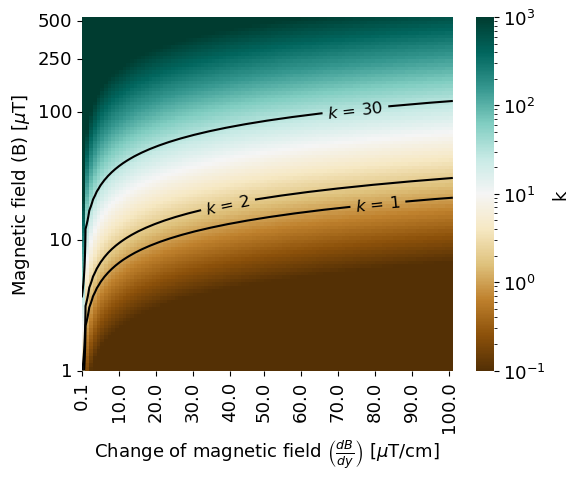

In [409]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=0.1, Vmax=1000)

plt.savefig('Photos/KvsField/dB_vs_B_klines.png', transparent=True)
plt.show()

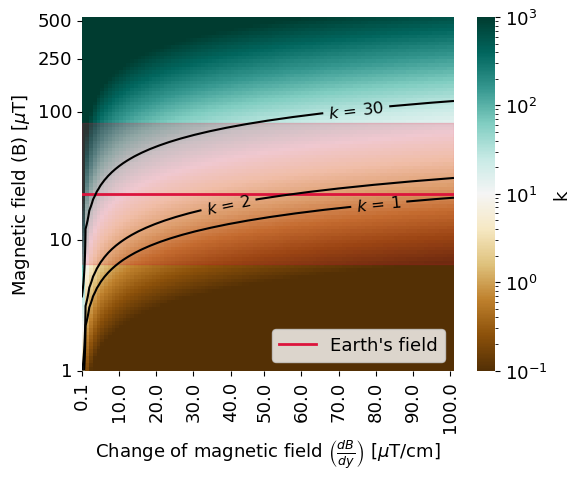

In [410]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)
plt.rcParams.update({'font.size': 13})

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

ax = rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr, Vmin=0.1, Vmax=1000)

colorEarth = 'crimson'
ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )

plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('Photos/KvsField/dB_vs_B_klines_earth.pdf', transparent=True)
plt.show()

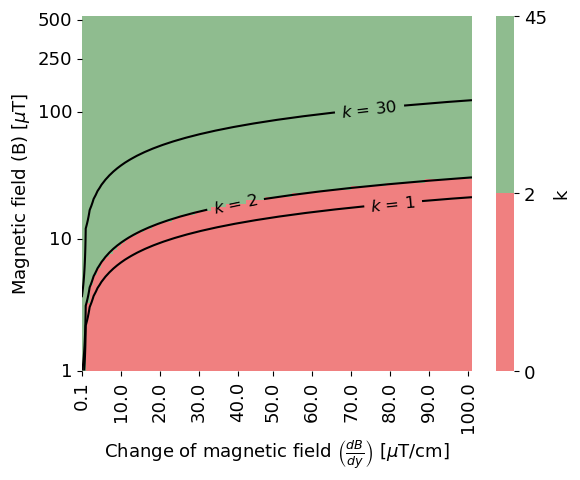

In [413]:
n = 100
# B_arr = np.linspace(1e-6, 500e-6, n)
#spaced evenly in log10 space
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0)

dbdx_arr = np.linspace(1e-5, 0.01, n) #T/m

ax = rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr,  R_G=True)

# colorEarth = 'g'
# ax.axhline(y=50, linewidth=2, color=colorEarth, zorder=1, label="Earth's field")
# ax.axhspan(50-20, 50+20, color=colorEarth, alpha=0.2, )

plt.tight_layout()
plt.savefig('Photos/KvsField/dB_vs_B_klines_redGreen.pdf', transparent=True)
plt.show()

In [17]:
# n = 100
# # B_arr = np.linspace(1e-6, 500e-6, n)
# #spaced evenly in log10 space
# B_arr = np.logspace(np.log10(.1e-6), np.log10(5e-6), num=n, base=10.0)
# dbdx_arr = np.linspace(1e-7, 0.0001, n) #T/m

# rangeOfdxdb_forK_customAxis(B_arr, dbdx_arr)#, Vmin=0.01, Vmax=100)

# plt.show()

In [18]:
# n = 55
# B_arr = np.linspace(1e-6, 1000e-6, n) #T
# dbdx_arr = np.linspace(.1, .6, n) #T/m

# rangeOfdxdb_forK(B_arr, dbdx_arr, Vmin=0.01, Vmax=100)
# plt.show()

## Attempt at a function of B field, gradient and a rotation
Uses Pierre equ 3.14 ideally

In [386]:
"""
Same as above, but with custom axis tick labels
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""   
def K_3vars_customAxis(B_df, oneVarVal, oneVar='B', xVar = 'dbdx', yVar = 'angle', 
                       di=1e-5, Vmin=None, Vmax=None, R_G=False, 
                       ticks = {'B' : np.array([1, 10, 100, 250, 500]),
                                'angle' : np.array([0, 20, 40, 60, 90]),
                                'dbdx' : np.array([.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])}
    ):
    # 'B', 'angle', 'dbdx'
        
    df_all = B_df.copy()
    #conversions
    df_all["B"] = df_all["B"]*1e6 #convert to uT
    df_all["dbdx"] = df_all["dbdx"]*1e6/100 #convert to uT/cm
    dx = Bs_df['dx'][0]
    
    df = df_all[(df_all[oneVar] < oneVarVal+di) & (df_all[oneVar] > oneVarVal-di)]
    
    lables = {
        'B' : "Magnetic field (B) [$\mu$T]",
        'angle' : f'Angle of rotation over {dx} m [deg]',
        'dbdx' : "Change of magnetic field $\\left( \\frac{dB}{dx} \\right) $ [$\mu$T/cm]",
    }
    
    units = {'B' : "$\mu$T",
            'angle' : 'deg',
            'dbdx' : "$\mu$T/cm"}
    
    color = { 
            'B' : "RdYlGn", #PiYG
            'angle' : 'BrBG',
            'dbdx' : "PRGn"}
    
    yticklabels_set = ticks[yVar]
    # the index position of the tick labels
    yticks = []    
    for label in yticklabels_set:
        idx_pos = FindClosest(df, label, yVar)
        yticks.append(len(df[yVar].unique())-idx_pos)
           
    xticklabels_set = ticks[xVar]
    # the index position of the tick labels
    xticks = []    
    for label in xticklabels_set:
        idx_pos = FindClosest(df, label, xVar)
        xticks.append(idx_pos)
    
    df = df.pivot(yVar, xVar, "k")
    df = df.reindex(index=df.index[::-1])
    # display(df)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    if R_G:
        #https://matplotlib.org/stable/gallery/color/custom_cmap.html
        #vibrant R/G
        # colors = [(0, (0.94118, 0.25882, 0.25882)), (1, (0.23137, 0.67059, 0.23137))]  # R -> G
        #less vibrant
        colors = [(0, 'lightcoral'), (1, 'darkseagreen')]  # R -> G
        
        n_bin = 2
        cmap_name = 'my_list'
        
        bounds = [0, 30, 45]
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
        q = sns.heatmap(df, cmap=cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N), 
                        linewidths=0, rasterized=True)
        # ax.collections[0].colorbar.set_ticklabels(['nonadiabatic','k = 30','adiabatic'])
        
    elif isinstance(Vmin, type(None)):
    #for a log scale colorbar
        q = sns.heatmap(df, cmap=color[oneVar], norm=mpl_colors.LogNorm(), linewidths=0, rasterized=True)        
    else:
        q = sns.heatmap(df, cmap=color[oneVar], norm=mpl_colors.LogNorm(vmin=Vmin, vmax=Vmax), 
                        linewidths=0, cbar=True, vmin=Vmin, vmax=Vmax, rasterized=True)#, yticklabels=yticklabels_set)
        
    smooth_scale = 1
    #remove any columns with infs
    df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    z = ndimage.zoom(df.to_numpy(), smooth_scale)
    
    cntr = ax.contour(np.linspace(0, len(df.columns), len(df.columns) * smooth_scale),
                      np.linspace(0, len(df.index), len(df.index) * smooth_scale),
                      z, levels=([1, 2, 30]), colors='black')

    ax.clabel(cntr, cntr.levels, inline=True, fmt=fmt_lable, fontsize=12)

    ax.collections[0].colorbar.set_label("k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels_set)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels_set)#,  rotation=0)
    

    ax.set_xlabel(lables[xVar])
    ax.set_ylabel(lables[yVar])
    ax.set_title(f"$k$ values for {oneVar}={oneVarVal:.2f} {units[oneVar]}")
    fig.tight_layout()
    return ax

In [256]:
def rotate(B_vec, angle):
    #and apply a rotation about the x axis by angle [rad]
    cos = round(np.cos(angle), 5)
    sin = round(np.sin(angle), 5)
    rotMatrix = np.array([[1, 0, 0],
                          [0, cos, sin],
                          [0, -sin, cos]])
    # print(rotMatrix)
    B_final = B_vec@rotMatrix
    return B_final

In [417]:
n = 200

'''
B value, by gradient (mag) by rotation angle
'''

dx = .2 #m
B_arr = np.logspace(np.log10(1e-6), np.log10(500e-6), num=n, base=10.0) #T
angle_arr = np.linspace(0, 90, n) #deg
dbdx_arr = np.linspace(0, 0.00001, n)/dx #T/m

# dbdx_arr = np.linspace(0, 0.01, n)/.3 #T/m

B_extend, ang_extend, dbdx_extend = np.meshgrid(B_arr, angle_arr, dbdx_arr)
B_extend = B_extend.flatten()
ang_extend = ang_extend.flatten()
dbdx_extend = dbdx_extend.flatten()

#now I need to create B1 and B2 values for each of these combos
# columns=['B [T]', 'angle [deg]', 'dbdx [T/m]'])

Bs_df = pd.DataFrame( np.array([B_extend, ang_extend, dbdx_extend, dx*np.ones(len(B_extend))]).T,
                   columns=['B', 'angle', 'dbdx', 'dx'])

B1_x = B_extend

B1_vec = np.zeros((len(B1_x), 3))
B1_vec[:,1] = B1_x.ravel()    
    
# apply the gradient to the y values of B2
B2_vec = B1_vec.copy()
B2_vec[:,1] = B2_vec[:,1]+ dbdx_extend

B2_vec = [rotate(B2_vec[i], np.radians(ang_extend[i])) for i, x in enumerate(ang_extend)]

Bs_df[['B_1x', 'B_1y', 'B_1z']] = B1_vec
Bs_df[['B_2x', 'B_2y', 'B_2z']] = B2_vec

In [418]:
B_1 = Bs_df[['B_1x', 'B_1y', 'B_1z']].to_numpy()
B_2 = Bs_df[['B_2x', 'B_2y', 'B_2z']].to_numpy()

K_arr = []

v_vec = [0, 8, 0]  #assuming neutron is traveling straight along the y axis


#assume each B1 and B2 are 1m apart - should prob make smaller tho
# r_1 = 1
# r_2 = 2
r_1 = [0,dx,0]

for i in range(len(B_1)):
    # K_arr.append(Adi.K_equ3_14(v_vec, B_1[i], B_2[i], r_1, r_2, k_inf_set=False))
    K_arr.append(Adi.K_equ3_12(8, B_1[i], B_2[i], r_1, k_inf_set=True))
    # K_arr.append(Adi.K_equ320(8, B_1[i], B_2[i], r_1, k_inf_set=True))
    
Bs_df['k'] = K_arr


KeyboardInterrupt



In [419]:
print(Bs_df['B'].unique()*1e6)
# print(Bs_df['angle'].unique())
# print(Bs_df['dbdx'].unique()*1e6/100 #convert to uT/cm)

# K_3vars_customAxis(B_df, oneVarVal, oneVar='B', xVar = 'dbdx', 
# yVar = 'angle', Vmin=None, Vmax=None, R_G=False):

ticks = {'B' : np.array([1, 10, 100, 250, 500]),
        'angle' : np.array([0, 20, 40, 60, 90]),
        'dbdx' : np.array([.1, 1, 10, 20, ])}

ax = K_3vars_customAxis(Bs_df, 1, Vmin=None, Vmax=None, R_G=1, ticks=ticks)
# ax = K_3vars_customAxis(Bs_df, 0, oneVar='angle', xVar = 'dbdx', yVar = 'B', R_G=False)
# ax = K_3vars_customAxis(Bs_df, 0, oneVar='dbdx', xVar = 'angle', yVar = 'B', R_G=False)

plt.tight_layout()

# plt.savefig('Photos/KvsField/angle_vs_dB_1_klines.pdf', transparent=True)
plt.savefig('Photos/KvsField/angle_vs_dB_1_klines_RG.pdf', transparent=True)

plt.show()

[  1.           1.03172193   1.06445015   1.09821656   1.13305412
   1.16899678   1.20607962   1.2443388    1.28381163   1.32453662
   1.36655348   1.4099032    1.45462806   1.50077167   1.54837905
   1.59749663   1.64817231   1.70045552   1.75439726   1.81005013
   1.86746842   1.92670813   1.98782704   2.05088475   2.11594278
   2.18306458   2.25231561   2.32376342   2.39747768   2.47353031
   2.55199548   2.63294971   2.71647196   2.8026437    2.89154898
   2.98327451   3.07790974   3.17554699   3.27628148   3.38021146
   3.48743831   3.59806659   3.71220422   3.82996252   3.95145633
   4.07680417   4.20612828   4.3395548    4.47721387   4.61923975
   4.76577096   4.91695043   5.07292561   5.23384862   5.39987641
   5.57117093   5.74789925   5.93023372   6.1183522    6.31243817
   6.51268091   6.71927574   6.93242416   7.15233406   7.37921992
   7.61330304   7.85481174   8.10398155   8.36105551   8.62628436
   8.89992678   9.18224966   9.47352838   9.77404701  10.08409868
  10.40398

KeyError: 'k'

## Work to get a true generalized version of 3.12 working

In [249]:
def K_equ3_12Update(v_n, B1, B2, deltaX, k_inf_set=False):
    B = LA.norm(B1)
   
    # the angle we rotate by
    theta = np.arccos(B1.T@B2/(LA.norm(B1)*LA.norm(B2)))
    
    omegaVecUnit = np.cross(B1, B2)
    #make sure the vectors aren't parallel before making it a unit vector
    if np.array_equal(omegaVecUnit, np.zeros(3)): 
        omegaVecUnit = omegaVecUnit
    else:
        omegaVecUnit /= np.linalg.norm(omegaVecUnit)
    
    #arbitrary rotation matrix -> to move B2 to the B1 frame
    RotMatrix = Rot.from_rotvec(theta*omegaVecUnit).as_matrix()
    
    dB_dy_rotFrame = (B2@RotMatrix-B1)/LA.norm(deltaX)
    
    #this does not assume that
    #gets direction angle angle of the angular 'velocity' vector rotation
    #-> Perp to B1 and B2
    #but this assumes that B2 is the velocity vector, not the next position vector
    #instead you need to use the dot produc to get the angle
    # omegaVec = np.cross(B1, B2)/(LA.norm(B1)*LA.norm(B2)) 

    if np.array_equal(omegaVecUnit, np.zeros(3)): 
        #vectors are parallel and there is no angular component
        omegaCrossB = omegaVecUnit
    else:
        # print(omegaVecUnit, theta)
        omega = np.array(omegaVecUnit*theta)/LA.norm(deltaX)
        omegaCrossB = np.cross(omega, B1)
    
    #the absolute value of our total derivative of B
    dabsB_dy = LA.norm(dB_dy_rotFrame + omegaCrossB)

    if dabsB_dy == 0:
        if k_inf_set:
            k = np.inf 
        else:
            k = 9e9
    else:
        k = gamma_n*B**2 / (v_n*dabsB_dy)

    return k

In [248]:
def K_equ3_12(v_n, B1, B2, deltaX, k_inf_set=False):
    B = LA.norm(B1)
   
    # omega = dphi/dy
    theta = np.arccos(B1.T@B2/(LA.norm(B1)*LA.norm(B2)))
    
    #this currently assumes that the field rotation is always about the x axis
    dB_dy_rotFrame = (rotate(B2, -theta)-B1)/LA.norm(deltaX)
    
    #the rotation angles make some things that should be 0, not exactly, but a 
    #very small value - need to check this works in general
    dB_dy_rotFrame = np.array([round(x, 8) for x in dB_dy_rotFrame])
    # print('db_dy =', dB_dy_rotFrame)
    
    #this does not assume that
    #gets direction angle angle of the angular 'velocity' vector rotation
    #-> Perp to B1 and B2
    #but this assumes that B2 is the velocity vector, not the next position vector
    #instead you need to use the dot produc to get the angle
    # omegaVec = np.cross(B1, B2)/(LA.norm(B1)*LA.norm(B2)) 
    omegaVecUnit = np.cross(B1, B2)
    # print(omegaVecUnit/np.linalg.norm(omegaVecUnit))

    if np.array_equal(omegaVecUnit, np.zeros(3)): 
        omegaCrossB = omegaVecUnit
    else:
        #vectors are parallel and there is no angular component
        omegaVecUnit /= np.linalg.norm(omegaVecUnit)

        # print(omegaVecUnit, theta)

        omega = np.array(omegaVecUnit*theta)/LA.norm(deltaX)
        omegaCrossB = np.cross(omega, B1)
    
    print(dB_dy_rotFrame, omegaCrossB)
    
    #the absolute value of our total derivative of B
    dabsB_dy = LA.norm(dB_dy_rotFrame + omegaCrossB)

    if dabsB_dy == 0:
        if k_inf_set:
            k = np.inf 
        else:
            k = 9e9
    else:
        k = gamma_n*B**2 / (v_n*dabsB_dy)

    return k

In [265]:
#why aren't these the same??
# print(Adi.pseudoScalar_K_equ3_14_turn(8, 1e-6, 1))

B1 = np.array([0,1e-6, 0])
theta = 40
# theta = np.linspace(.1, 90)
        
B2 = rotate(B1, np.radians(theta))
print("B2:", B2)
# print("cross:", np.cross(B1, B2)/())

# B2 = np.array([0,0, 1e-6])

k_314 = Adi.K_equ3_14(np.array([0,8, 0]), B1, B2, 
                    np.array([0,0,0]), np.array([0,1,0])) #* np.radians(theta))


K_312 = K_equ3_12(8,  B1, B2, [0,1,0])
K_320 =  Adi.K_equ320(8, B1, B2, [0,1,0])

print('ks:', k_314, K_312, K_312/k_314)
# print(K_320)

thetaAngle = np.arccos(B1@B2/(LA.norm(B1)*LA.norm(B2)))
print(thetaAngle*LA.norm(B1))
# print(thetaAngle)

B2: [0.0000e+00 7.6604e-07 6.4279e-07]
[ 0. -0.  0.] [0.00000000e+00 0.00000000e+00 6.98136388e-07]
ks: 32.81005942797611 32.81005942797611 1.0
6.981363878746547e-07


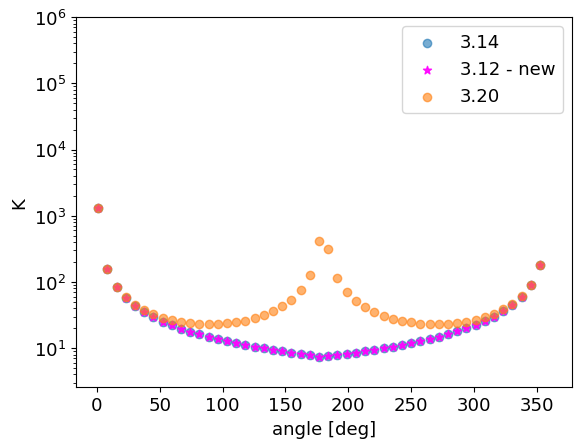

[0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [406]:
#why aren't these the same??

B1 = np.array([0, 1e-6, 0])
theta = np.linspace(1, 360)
k_314 = []
K_312_a = []
K_320_a = []

for t in np.radians(theta):
    B2 = rotate(B1, t)
    # print("B2:", B2)
    # B2 = np.array([0,0, 1e-6])

    k_314.append(Adi.K_equ3_14(np.array([0,8, 0]), B1, B2, 
                        np.array([0,0,0]), np.array([0,1,0]))) #* np.radians(theta))

    K_312_a.append(Adi.K_equ3_12(8,  B1, B2, [0,1,0]))
    K_320_a.append(Adi.K_equ320(8,  B1, B2, [0,1,0]))

plt.scatter(theta, k_314, label='3.14', alpha=0.6)
plt.scatter(theta, K_312_a, label='3.12 - new', alpha=0.9, color='magenta', marker="*")
plt.scatter(theta, K_320_a, label='3.20', alpha=0.6)

plt.xlabel("angle [deg]")
plt.ylabel("K_312/k_314")
plt.ylabel("K")

# plt.scatter(theta, np.array(K_312_a)/k_314)
# plt.axhline(np.degrees(np.pi/2))
plt.legend()
plt.yscale('log')
plt.ylim(None, 1e6)

plt.show()
# print((np.array(K_320_a)/np.array(k_314)))
print((np.array(K_312_a)/np.array(k_314)))
# print((np.array(K_312_a)/np.array(K_320_a)))


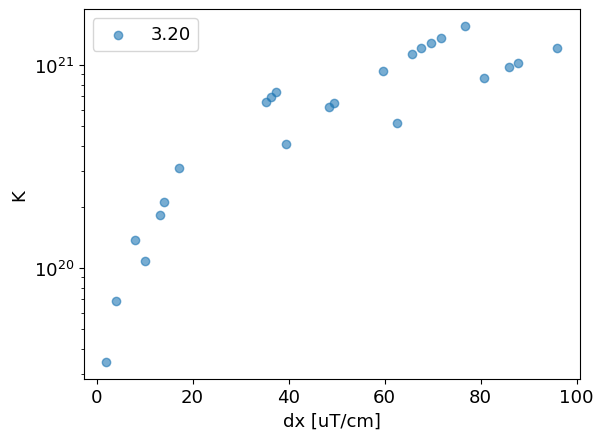

In [281]:
#why aren't these the same??

B1 = np.array([0, 1e-6, 0])
dxdy = np.linspace(0, 0.01, n)
k_314 = []
K_312_a = []
K_320_a = []

for dx in dxdy:
    B2 = B1.copy() 
    B2[1] =+ dx
    # print("B2:", B2)
    # B2 = np.array([0,0, 1e-6])

    k_314.append(Adi.K_equ3_14(np.array([0,8, 0]), B1, B2, 
                        np.array([0,0,0]), np.array([0,1,0]))) #* np.radians(theta))

    K_312_a.append(Adi.K_equ3_12(8,  B1, B2, [0,1,0]))
    K_320_a.append(Adi.K_equ320(8,  B1, B2, [0,1,0]))

# *1e6/100 #convert to uT/cm)
# plt.scatter(dxdy*1e6/100, k_314, label='3.14', alpha=0.6)
# plt.scatter(dxdy*1e6/100, K_312_a, label='3.12 - gen', alpha=0.9, color='magenta', marker="*")
plt.scatter(dxdy*1e6/100, K_320_a, label='3.20', alpha=0.6)

plt.xlabel("dx [uT/cm]")
plt.ylabel("K_312/k_314")
plt.ylabel("K")

# plt.scatter(theta, np.array(K_312_a)/k_314)
# plt.axhline(np.degrees(np.pi/2))
# plt.ylim(0, 60)
plt.legend()
plt.yscale('log')
plt.show()
# print((np.array(K_320_a)/np.array(k_314)))
# print((np.array(K_312_a)/np.array(k_314)))
# print((np.array(K_312_a)/np.array(K_320_a)))
